In [1]:
import os
import json
from types import SimpleNamespace
from collections import Counter
import numpy as np
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
try:
    from sklearn.cluster import KMeans
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print("[WARN] sklearn not installed, KMeans clustering will be skipped.")

import MT_baselines as mt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

/home/xuyilin/miniconda3/envs/CS5689/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [2]:
# Cell 2: choose experiment
OUTDIR = "runs_mt"

# 举例：分析 transformer + whitespace + ls=0.2
RUN_NAME = "tfm_ws_seed42_ls02"
EXP_DIR = os.path.join(OUTDIR, RUN_NAME)

print("Experiment dir:", EXP_DIR)

print("Files:", os.listdir(EXP_DIR))

Experiment dir: runs_mt/tfm_ws_seed42_ls02
Files: ['loss_curves.png', 'metrics.json', 'train.log', 'args.json', 'transformer_best.pt']


In [3]:
# Cell 3: load args & checkpoint, rebuild model

# 1) 加载训练时的 args
args_path = os.path.join(EXP_DIR, "args.json")
with open(args_path, "r", encoding="utf-8") as f:
    args_dict = json.load(f)
args = SimpleNamespace(**args_dict)

print("Loaded args.model =", args.model)
print("Loaded tokenizer =", args.tokenizer)

# 2) 加载 best checkpoint
ckpt_path = os.path.join(EXP_DIR, f"{args.model}_best.pt")
ckpt = torch.load(ckpt_path, map_location=DEVICE)
print("Checkpoint keys:", ckpt.keys())

src_vocab = ckpt["src_vocab"]
tgt_vocab = ckpt["tgt_vocab"]
config = ckpt["config"]
model_type = config["model_type"]

print("Model type in ckpt:", model_type)
print("Src vocab size:", len(src_vocab["itos"]))
print("Tgt vocab size:", len(tgt_vocab["itos"]))

# 3) 构建与训练时一致的模型结构
src_pad_idx = src_vocab["stoi"][mt.SPECIAL_TOKENS["pad"]]
tgt_pad_idx = tgt_vocab["stoi"][mt.SPECIAL_TOKENS["pad"]]

if model_type == "transformer":
    model = mt.TransformerSeq2Seq(
        src_vocab_size=config["src_vocab_size"],
        tgt_vocab_size=config["tgt_vocab_size"],
        src_pad_idx=src_pad_idx,
        tgt_pad_idx=tgt_pad_idx,
        d_model=config["d_model"],
        nhead=config["nhead"],
        num_encoder_layers=config["num_encoder_layers"],
        num_decoder_layers=config["num_decoder_layers"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
    )
elif model_type == "rnn_gru":
    enc = mt.Encoder(
        vocab_size=config["src_vocab_size"],
        emb_dim=config["emb_dim"],
        hid_dim=config["hid_dim"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
    )
    dec = mt.Decoder(
        vocab_size=config["tgt_vocab_size"],
        emb_dim=config["emb_dim"],
        enc_hid_dim=config["hid_dim"],
        dec_hid_dim=config["hid_dim"],
        dropout=config["dropout"],
    )
    model = mt.Seq2Seq(enc, dec, src_pad_idx, tgt_pad_idx, device=DEVICE)
elif model_type == "rnn_lstm":
    enc = mt.EncoderLSTM(
        vocab_size=config["src_vocab_size"],
        emb_dim=config["emb_dim"],
        hid_dim=config["hid_dim"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
        bidirectional=True,
    )
    dec = mt.DecoderLSTM(
        vocab_size=config["tgt_vocab_size"],
        emb_dim=config["emb_dim"],
        enc_hid_dim=config["hid_dim"],
        dec_hid_dim=config["hid_dim"],
        dropout=config["dropout"],
    )
    model = mt.Seq2SeqLSTM(enc, dec, src_pad_idx, tgt_pad_idx, device=DEVICE)
else:
    raise ValueError(f"Unknown model_type in ckpt: {model_type}")

# 4) 加载权重
mt.load_model_state(model, ckpt["model_state"])
model.to(DEVICE)
model.eval()

print("Model loaded and ready on", DEVICE)

Loaded args.model = transformer
Loaded tokenizer = whitespace


/tmp/ipykernel_467764/3529830736.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=DEVICE)


Checkpoint keys: dict_keys(['model_state', 'src_vocab', 'tgt_vocab', 'config', 'optimizer_state', 'best_val_loss', 'epoch', 'use_amp', 'args', 'scaler_state', 'scheduler_state'])
Model type in ckpt: transformer
Src vocab size: 20000
Tgt vocab size: 20000
Model loaded and ready on cuda


In [4]:
# Cell 4: rebuild train/val loaders (for data exploration)

# 注意：build_data 会使用 args.tokenizer 等参数，
#       但我们传入 src_vocab/tgt_vocab，因此不会重新 build vocab

(src_vocab2,
 tgt_vocab2,
 src_pad_idx2,
 tgt_pad_idx2,
 train_loader,
 val_loader) = mt.build_data(args, src_vocab=src_vocab, tgt_vocab=tgt_vocab)

print("Train dataset size:", len(train_loader.dataset))
print("Val dataset size:", len(val_loader.dataset))


Train dataset size: 206061
Val dataset size: 888


In [5]:
# Cell 5: sentence length distribution & token frequency

src_pad = src_vocab["stoi"][mt.SPECIAL_TOKENS["pad"]]
tgt_pad = tgt_vocab["stoi"][mt.SPECIAL_TOKENS["pad"]]
src_bos = src_vocab["stoi"][mt.SPECIAL_TOKENS["bos"]]
src_eos = src_vocab["stoi"][mt.SPECIAL_TOKENS["eos"]]
tgt_bos = tgt_vocab["stoi"][mt.SPECIAL_TOKENS["bos"]]
tgt_eos = tgt_vocab["stoi"][mt.SPECIAL_TOKENS["eos"]]

src_lengths = []
tgt_lengths = []
src_counter = Counter()
tgt_counter = Counter()

for src_batch, tgt_batch in train_loader:
    # 长度（非 pad token 数，包括 BOS/EOS）
    src_len_batch = (src_batch != src_pad).sum(dim=1).tolist()
    tgt_len_batch = (tgt_batch != tgt_pad).sum(dim=1).tolist()

    src_lengths.extend(src_len_batch)
    tgt_lengths.extend(tgt_len_batch)

    # token 频率（忽略 pad/bos/eos）
    for seq in src_batch:
        for idx in seq.tolist():
            if idx in (src_pad, src_bos, src_eos):
                continue
            src_counter[idx] += 1

    for seq in tgt_batch:
        for idx in seq.tolist():
            if idx in (tgt_pad, tgt_bos, tgt_eos):
                continue
            tgt_counter[idx] += 1

print(f"Source length: mean={np.mean(src_lengths):.2f}, median={np.median(src_lengths):.2f}, max={np.max(src_lengths)}")
print(f"Target length: mean={np.mean(tgt_lengths):.2f}, median={np.median(tgt_lengths):.2f}, max={np.max(tgt_lengths)}")


Source length: mean=19.30, median=16.00, max=82
Target length: mean=18.02, median=15.00, max=82


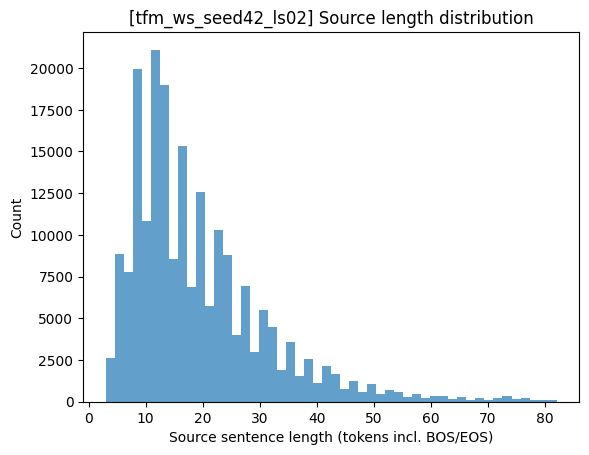

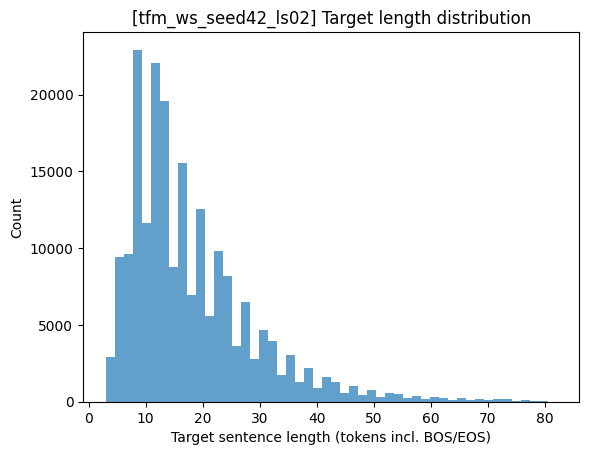

In [6]:
# Cell 6: plot length histograms

plt.figure()
plt.hist(src_lengths, bins=50, alpha=0.7)
plt.xlabel("Source sentence length (tokens incl. BOS/EOS)")
plt.ylabel("Count")
plt.title(f"[{RUN_NAME}] Source length distribution")
plt.show()

plt.figure()
plt.hist(tgt_lengths, bins=50, alpha=0.7)
plt.xlabel("Target sentence length (tokens incl. BOS/EOS)")
plt.ylabel("Count")
plt.title(f"[{RUN_NAME}] Target length distribution")
plt.show()


In [7]:
plt.savefig(os.path.join(EXP_DIR, "src_length_hist.png"), dpi=200, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

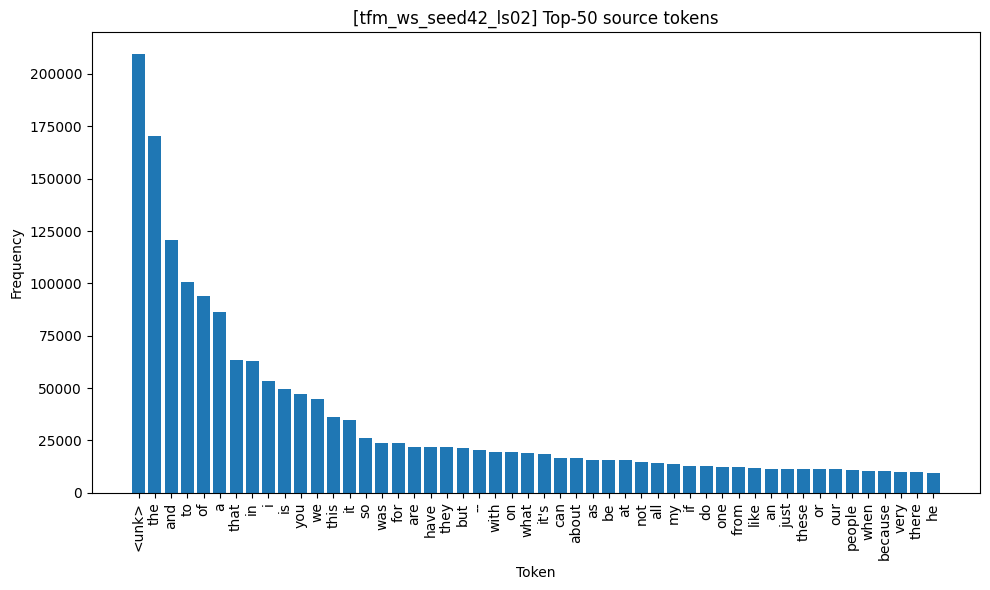

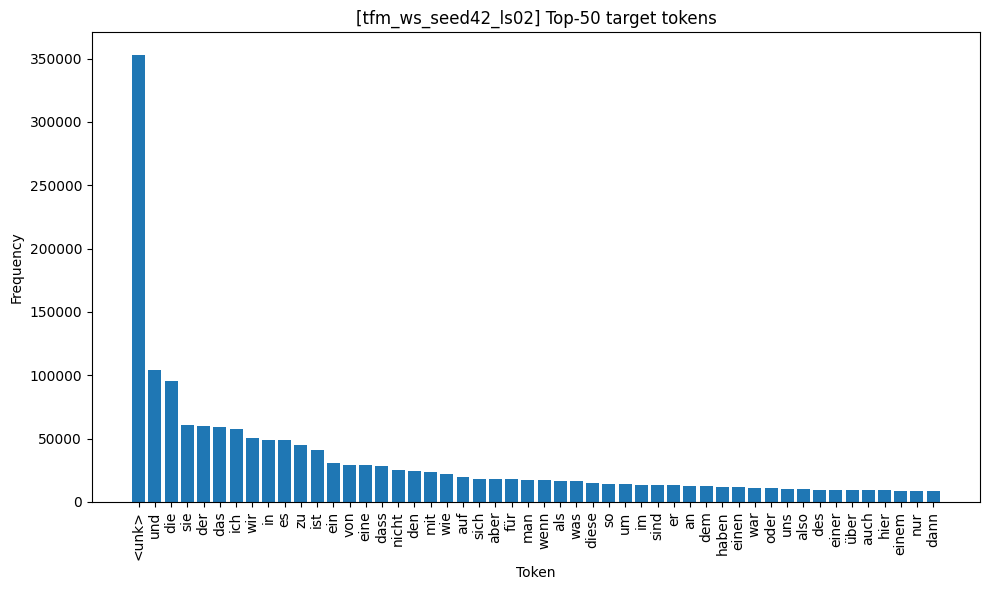

In [8]:
# Cell 7: top-K token frequencies

def plot_top_tokens(counter, vocab, title, k=50):
    itos = vocab["itos"]
    most_common = counter.most_common(k)
    tokens = [itos[idx] if idx < len(itos) else f"<{idx}>" for idx, _ in most_common]
    freqs = [cnt for _, cnt in most_common]

    plt.figure(figsize=(max(8, k * 0.2), 6))
    plt.bar(range(len(tokens)), freqs)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.xlabel("Token")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_tokens(src_counter, src_vocab, f"[{RUN_NAME}] Top-50 source tokens", k=50)
plot_top_tokens(tgt_counter, tgt_vocab, f"[{RUN_NAME}] Top-50 target tokens", k=50)


Embedding shape: torch.Size([20000, 256])
PCA 2D shape: (2000, 2)


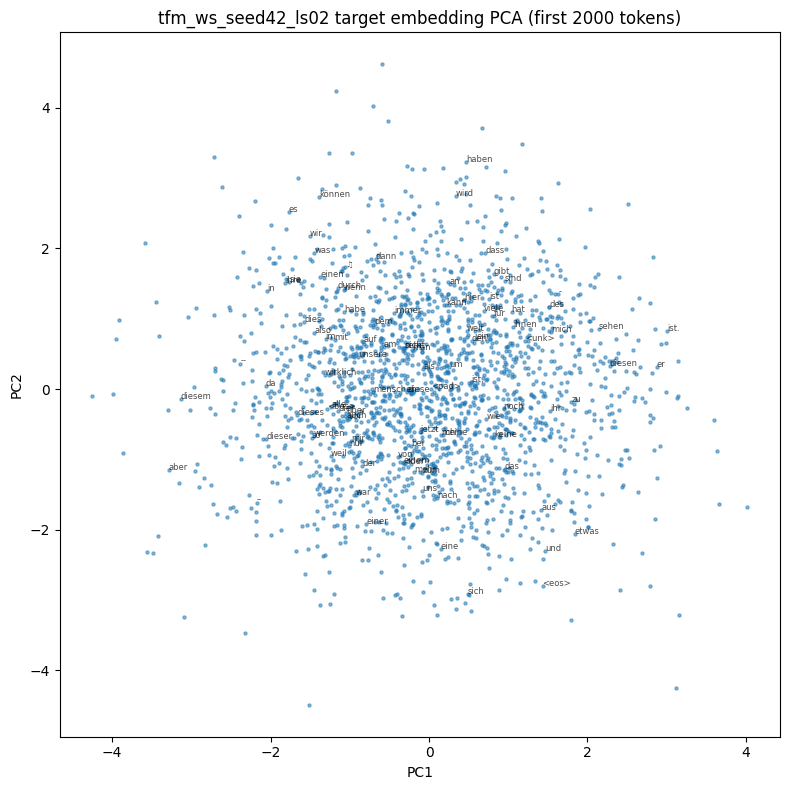

In [9]:
# Cell 8: PCA on target embedding

core_model = model
if isinstance(core_model, torch.nn.DataParallel):
    core_model = core_model.module

# 找 target embedding
if hasattr(core_model, "decoder") and hasattr(core_model.decoder, "embedding"):
    emb_weight = core_model.decoder.embedding.weight.detach().cpu()
elif hasattr(core_model, "tgt_embedding"):
    emb_weight = core_model.tgt_embedding.weight.detach().cpu()
else:
    raise RuntimeError("Cannot find target embedding in model.")

print("Embedding shape:", emb_weight.shape)  # [V, D]

V, D = emb_weight.shape
max_tokens = min(2000, V)
X = emb_weight[:max_tokens]

# 中心化
X_center = X - X.mean(dim=0, keepdim=True)

# 用 torch.pca_lowrank 做 PCA
U, S, Vt = torch.pca_lowrank(X_center, q=2)
X_2d = (X_center @ Vt[:, :2]).numpy()

print("PCA 2D shape:", X_2d.shape)

# 画图 + 标注前 100 个 token
itos = tgt_vocab["itos"]

plt.figure(figsize=(8, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=5, alpha=0.5)

num_annotate = min(100, max_tokens)
for i in range(num_annotate):
    token = itos[i] if i < len(itos) else f"<{i}>"
    plt.annotate(token, (X_2d[i, 0], X_2d[i, 1]), fontsize=6, alpha=0.7)

plt.title(f"{RUN_NAME} target embedding PCA (first {max_tokens} tokens)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [10]:
# Cell 9: K-means clustering on embeddings (optional, requires sklearn)

if not SKLEARN_AVAILABLE:
    print("sklearn not installed; skipping KMeans.")
else:
    n_clusters = 20
    print(f"Running KMeans with n_clusters={n_clusters} on {max_tokens} embeddings...")
    km = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
    labels = km.fit_predict(X.numpy())

    # 每个 cluster 打印几个词
    clusters = {i: [] for i in range(n_clusters)}
    for idx, c in enumerate(labels):
        token = itos[idx] if idx < len(itos) else f"<{idx}>"
        clusters[c].append(token)

    for c in range(n_clusters):
        # 只显示前 15 个 token
        print(f"\nCluster {c}:")
        print(", ".join(clusters[c][:15]))

Running KMeans with n_clusters=20 on 2000 embeddings...

Cluster 0:
als, war, auch, noch, wird, drei, seine, hat,, macht, könnte, es,, jedes, gibt,, habe,, raum

Cluster 1:
auf, einem, durch, keine, eines, wahrscheinlich, beim, dinge,, begann, sah, weitere, hand, hause, wichtig,, bereich

Cluster 2:
und, was, immer, diesen, müssen, sind., nicht,, genau, können,, vielen, denen, großen, arbeit, jemand, glaube,

Cluster 3:
der, sich, aber, hier, nur, dieser, jetzt, viel, denn, jahren, sie,, geht, meiner, ihren, davon

Cluster 4:
<unk>, werden, viele, zwei, zeit, mal, unter, werden,, sagte:, vier, ungefähr, weniger, wer, fünf, frauen

Cluster 5:
haben, einer, etwas, kann, bei, zum, leben, wurde, selbst, ohne, zwischen, gab, machen., will, würden

Cluster 6:
wir, von, wie, über, hat, sein, andere, schon, ob, sein., etwa, letzten, große, ersten, kleinen

Cluster 7:
ich, für, um, mich, ist., jahre, tatsächlich, sogar, kann., ganzen, ging, zurück, pro, wenig, eigenen

Cluster 8:
<pad>, nicht, 